# Expanse Notebook for Computational Analysis of Chromatin During Heart Development

This notebook will be used exclusively to perform expensive operations on Expanse. 

### Setup

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

In [9]:
# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'



In [10]:
# LOADING DATA

bin_map = f.load_bin_map(BIN_MAP_PATH)
contact_matrix_zero = np.load('samples/contact_matrix_100kb_balanced_zeroed.npy')
neighbors, cdfs = f.build_walk_index(contact_matrix_zero) 
gene_bins = [int(line.strip()) for line in open(GENE_BIN_PATH).readlines()]
non_gene_bins = [int(line.strip()) for line in open(NON_GENE_BIN_PATH).readlines()]

100%|██████████| 30894/30894 [00:12<00:00, 2543.23it/s]


## Fold Change vs Reset Alpha

In [ ]:
scores = background_model.create_rw_multiprocessing(contact_matrix_zero, clique_size, num_iterations=10000, neighbors=neighbors, cdfs=cdfs)

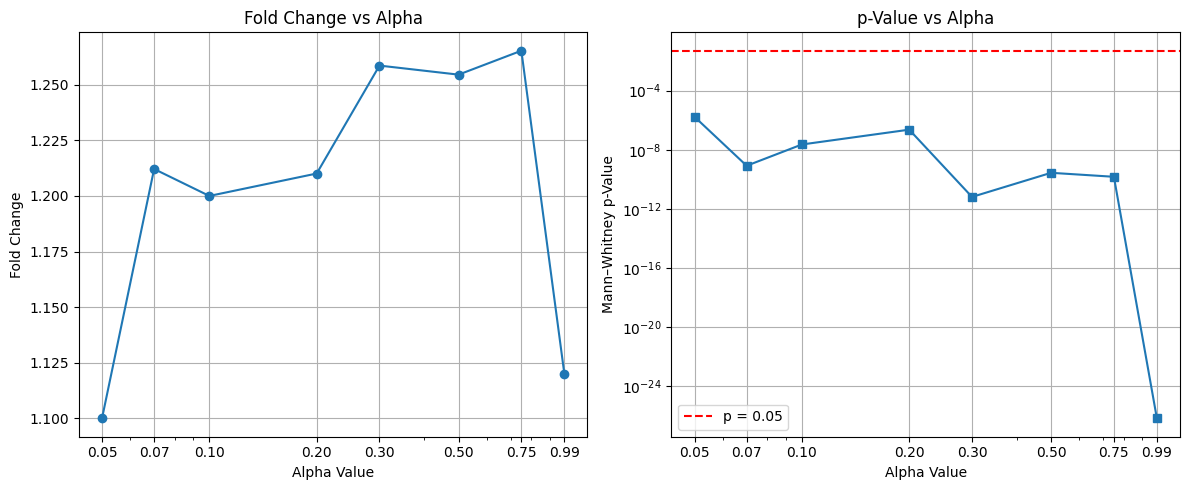

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import ScalarFormatter

clique_size     = 10
num_iterations  = 1000
alphas          = [0.05, 0.07, 0.1, 0.2, 0.3, 0.5, 0.75, 0.99]

fold_changes = []
p_values     = []

for alpha in alphas:
    bg_strong = []
    bg_weak = []

    strong_path = f'background_models/random_walk/rw_scores_{clique_size}_molecules_10000_iters_{num_iterations}_alpha_{alpha}_strong.txt'
    weak_path   = f'background_models/random_walk/rw_scores_{clique_size}_molecules_10000_iters_{num_iterations}_alpha_{alpha}_weak.txt'

    with open(strong_path, 'r') as input_file:
        for line in input_file:
            line = line.strip()
            if line:
                bg_strong.append(float(line))

    with open(weak_path, 'r') as input_file:
        for line in input_file:
            line = line.strip()
            if line:
                bg_weak.append(float(line))

    bg_strong = np.array(bg_strong)
    bg_weak = np.array(bg_weak)

    fold_change = np.median(bg_strong) / np.median(bg_weak)
    _, p_value  = stats.mannwhitneyu(bg_strong, bg_weak, alternative='greater')

    fold_changes.append(fold_change)
    p_values.append(p_value)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Fold-Change vs alpha
ax1.plot(alphas, fold_changes, marker='o')
ax1.set_xscale('log')
ax1.set_xticks(alphas)
ax1.get_xaxis().set_major_formatter(ScalarFormatter())
ax1.set_xlabel('Alpha Value')
ax1.set_ylabel('Fold Change')
ax1.set_title('Fold Change vs Alpha')
ax1.grid(True)

# p-value vs alpha with p=0.05 line
ax2.plot(alphas, p_values, marker='s')
ax2.axhline(0.05, linestyle='--', color='red', label='p = 0.05')
ax2.set_xscale('log')
ax2.set_xticks(alphas)
ax2.get_xaxis().set_major_formatter(ScalarFormatter())
ax2.set_xlabel('Alpha Value')
ax2.set_ylabel('Mann–Whitney p-Value')
ax2.set_title('p-Value vs Alpha')

max_p = max(p_values)
# top = (max_p * 1.1)/20
# ax2.set_ylim(0, top)
ax2.set_yscale('log')   


ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Get 40-Clique of TTN and Corresponding Genes

In [9]:
top_40_clique_rw = cf.random_walk(contact_matrix_zero, TTN_BIN, 40, num_molecules=100000, alpha=0.05, neighbors=neighbors, cdfs=cdfs)

In [11]:
top_40_clique_greedy = cf.find_greedy_clique(
    contact_matrix_zero, 40, TTN_BIN
)

In [13]:
core.stats.calculate_avg_interaction_strength(
    contact_matrix_zero, top_40_clique_greedy
)

0.0005394067415183999

In [11]:
# overlapping nodes from the two cliques
overlapping_nodes = np.intersect1d(top_40_clique_rw, top_40_clique_greedy)
print("Overlapping nodes between the two cliques:")
print(overlapping_nodes)


Overlapping nodes between the two cliques:
[ 4275 30357 30369 30478]


In [12]:
start = time()
top_40_diffusion = cf.analytical_diffusion_clique(contact_matrix_zero, TTN_BIN, 40, alpha=0.05)[0]

end = time()
print("TTN Clique:", top_40_diffusion)
print(f"Time taken: {end - start} seconds")

with open("TTN_BINS_ANALYTICAL_DIFFUSION.txt", 'w') as out:
    for bin in top_40_diffusion:
        out.write(f"{bin}\n")


TTN Clique: [ 4275 30478 28240 28248 30543 27873 30350 30378 30387 30386 30369 30432
 30586 30357 28243 30434 28236 21918 27880 30423 24025 27887 28358 27881
 28361 28377 28366 27139 20604 27886 28247 28364 27889 11886 30359 19160
 27835  8796 28212 21915]
Time taken: 417.7960503101349 seconds


In [13]:
# overlapping nodes from the two cliques
overlapping_nodes_diffusion = np.intersect1d(top_40_clique_rw, top_40_diffusion)
print("Overlapping nodes between the two cliques:")
print(overlapping_nodes_diffusion)

Overlapping nodes between the two cliques:
[ 4275 24025 27873 27881 27887 28236 28248 28364 30357 30369 30378 30478
 30543 30586]


In [15]:
from tqdm import tqdm

TTN_GENES = set()
for bin in tqdm(top_40_diffusion):
    genes = f.find_gene_from_bin(bin, BIN_MAP_PATH, GTF_PATH)
    TTN_GENES.update(genes)


    

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:43<00:00, 10.08s/it]


In [16]:
with open("TTN_GENES_ANALYTICAL_DIFFUSION.txt", 'w') as out:
    for bin in TTN_GENES:
        out.write(f"{bin}\n")
